# **Hyperparameter Tuning with Keras Tuner**

### CSCI 7000: Applied Deep Learning (Homework 1)

**Note: As I already have some experience with TensorFlow and Keras, I will take this opportunity to check out a new hyperparameter tuning tool for Keras.**

**This notebook was created with Google Colaboratory, and uses some special features available in Colab.**

In [1]:
# Specify that we want to use TensorFlow 2.
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
# Install Keras Tuner.
!pip install -q keras-tuner

     |████████████████████████████████| 61kB 1.6MB/s 


**Now we're in business. First, we import relevant libraries.**

In [ ]:
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import kerastuner

**Since we're focusing on hyperparameter tuning, let's save some time and use an easily available dataset, Fashion-MNIST [1].**

**[1] Han Xiao, Kashif Rasul and Roland Vollgraf. 2017. Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. arXiv:1708.07747 [cs.LG].**

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Look at data set shapes.
print('Training set shape:', x_train.shape)
print('Testing set shape:', x_test.shape)

# Set class names for future use.
classes = ['T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

4423680/4422102 [==============================] - 0s 0us/step
Training set shape: (60000, 28, 28)
Testing set shape: (10000, 28, 28)


**Let's look at one instance of each clothing item.**

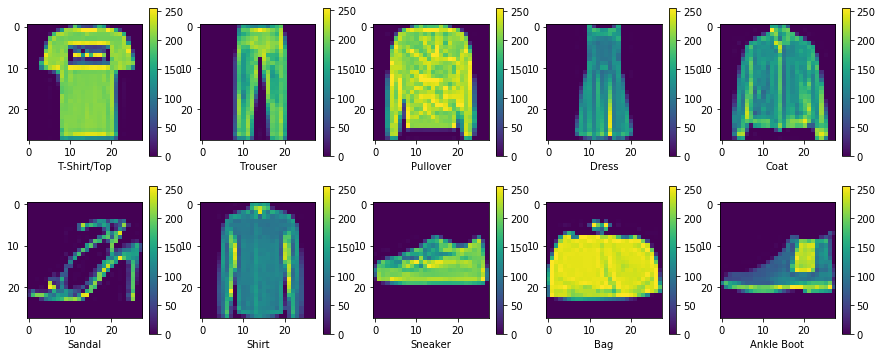

In [5]:
i = 0
plt.figure(figsize=(15, 6))

for item in range(10):
  # Janky (but quick) way of getting unique classes.
  while True:
    if y_train[i] != item:
      i += 1
    else:
      break
  
  # Make the subplots.
  plt.subplot(2, 5, item + 1)
  plt.imshow(x_train[i])
  plt.xlabel(classes[y_train[i]])
  plt.colorbar()

plt.show()

**Very nice. Should probably normalize those pixel values.**

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

**Using Keras Tuner is pretty straightforward. We define a Keras model as usual, but we first wrap the model definition within a function that takes an argument `hp`.**

**During the model definition, we sample hyperparameters from `hp`, e.g. `hp.Int('dense_units' + str(i), 64, 512, step=64)`.**

**To save on computation time (since hyperparameter tuning is quite compute-intensive), we won't use convolutional layers in the model.**

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(layers.Flatten(input_shape=(28, 28)))

  # Keras Tuner supports nested hyperparameters.
  # Here, we tune the number of dense layers, then tune the number of units in each layer.
  for i in range(hp.Int('dense_layers', 1, 3, step=1)):
    model.add(layers.Dense(hp.Int('dense_units_' + str(i), 64, 512, step=64),
                         activation='relu'))
  
  # Add a final softmax layer.
  model.add(layers.Dense(10,
                         activation='softmax'))

  model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

**Keras Tuner provides a few tuners: Bayesian optimization, Hyperband, and random search. Let's try Hyperband [2].**

**[2] Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, and Ameet Talwalkar. 2017. Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization. Journal of Machine Learning Research 18: 1-52.**

In [ ]:
tuner = kerastuner.Hyperband(build_model,
                             objective='val_accuracy',
                             max_epochs=12, # maximum number of epochs for each model
                             hyperband_iterations=2) # number of times to iterate over the full Hyperband algorithm

**We can look at a summary of the search space.**

In [9]:
tuner.search_space_summary()

**Let's start searching! This call takes the same arguments as Keras's `model.fit()`.**

In [10]:
tuner.search(x_train,
             y_train,
             validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 8s 136us/sample - loss: 0.5407 - accuracy: 0.8124 - val_loss: 0.5380 - val_accuracy: 0.8258
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: 0.4314 - accuracy: 0.8444 - val_loss: 0.4283 - val_accuracy: 0.8469


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.5442 - accuracy: 0.8040 - val_loss: 0.4497 - val_accuracy: 0.8371
Epoch 2/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4384 - accuracy: 0.8425 - val_loss: 0.4284 - val_accuracy: 0.8452


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 117us/sample - loss: 0.5900 - accuracy: 0.7889 - val_loss: 0.5089 - val_accuracy: 0.8286
Epoch 2/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.4824 - accuracy: 0.8300 - val_loss: 0.5592 - val_accuracy: 0.7963


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4800 - accuracy: 0.8282 - val_loss: 0.4361 - val_accuracy: 0.8435
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3601 - accuracy: 0.8692 - val_loss: 0.3988 - val_accuracy: 0.8554


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 113us/sample - loss: 0.4719 - accuracy: 0.8282 - val_loss: 0.4290 - val_accuracy: 0.8501
Epoch 2/2
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3641 - accuracy: 0.8670 - val_loss: 0.3741 - val_accuracy: 0.8643


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 105us/sample - loss: 0.4708 - accuracy: 0.8329 - val_loss: 0.4342 - val_accuracy: 0.8384
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3608 - accuracy: 0.8681 - val_loss: 0.4226 - val_accuracy: 0.8413


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 112us/sample - loss: 0.5840 - accuracy: 0.7918 - val_loss: 0.5011 - val_accuracy: 0.8210
Epoch 2/2
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4790 - accuracy: 0.8317 - val_loss: 0.5716 - val_accuracy: 0.8138


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 8s 127us/sample - loss: 0.5890 - accuracy: 0.7890 - val_loss: 0.5362 - val_accuracy: 0.8250
Epoch 2/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.4666 - accuracy: 0.8380 - val_loss: 0.4806 - val_accuracy: 0.8379


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5638 - accuracy: 0.8004 - val_loss: 0.5191 - val_accuracy: 0.8102
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4533 - accuracy: 0.8386 - val_loss: 0.4672 - val_accuracy: 0.8316


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5595 - accuracy: 0.8040 - val_loss: 0.5366 - val_accuracy: 0.8109
Epoch 2/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4461 - accuracy: 0.8415 - val_loss: 0.4455 - val_accuracy: 0.8457


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4734 - accuracy: 0.8302 - val_loss: 0.4064 - val_accuracy: 0.8527
Epoch 2/2
60000/60000 [==============================] - 6s 101us/sample - loss: 0.3589 - accuracy: 0.8698 - val_loss: 0.4024 - val_accuracy: 0.8490


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.5585 - accuracy: 0.8047 - val_loss: 0.4711 - val_accuracy: 0.8354
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4492 - accuracy: 0.8401 - val_loss: 0.4728 - val_accuracy: 0.8387


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.4797 - accuracy: 0.8258 - val_loss: 0.4598 - val_accuracy: 0.8346
Epoch 4/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3640 - accuracy: 0.8672 - val_loss: 0.3723 - val_accuracy: 0.8625


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4803 - accuracy: 0.8285 - val_loss: 0.4195 - val_accuracy: 0.8503
Epoch 4/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3630 - accuracy: 0.8676 - val_loss: 0.4085 - val_accuracy: 0.8490


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4801 - accuracy: 0.8272 - val_loss: 0.4089 - val_accuracy: 0.8548
Epoch 4/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3626 - accuracy: 0.8663 - val_loss: 0.3916 - val_accuracy: 0.8618


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.5399 - accuracy: 0.8129 - val_loss: 0.5047 - val_accuracy: 0.8244
Epoch 4/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.4353 - accuracy: 0.8446 - val_loss: 0.4817 - val_accuracy: 0.8274


Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 114us/sample - loss: 0.4778 - accuracy: 0.8254 - val_loss: 0.5173 - val_accuracy: 0.8170
Epoch 6/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3655 - accuracy: 0.8660 - val_loss: 0.3652 - val_accuracy: 0.8692
Epoch 7/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3292 - accuracy: 0.8784 - val_loss: 0.3680 - val_accuracy: 0.8631
Epoch 8/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3074 - accuracy: 0.8867 - val_loss: 0.3710 - val_accuracy: 0.8684
Epoch 9/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.2886 - accuracy: 0.8921 - val_loss: 0.3455 - val_accuracy: 0.8763
Epoch 10/12
60000/60000 [==============================] - 6s 105us/sample - loss: 0.2741 - accuracy: 0.8961 - val_loss: 0.3523 - val_accuracy: 0.8762
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4783 - accuracy: 0.8282 - val_loss: 0.4154 - val_accuracy: 0.8510
Epoch 6/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3590 - accuracy: 0.8684 - val_loss: 0.3698 - val_accuracy: 0.8652
Epoch 7/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3249 - accuracy: 0.8796 - val_loss: 0.3436 - val_accuracy: 0.8734
Epoch 8/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3028 - accuracy: 0.8874 - val_loss: 0.3508 - val_accuracy: 0.8749
Epoch 9/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2835 - accuracy: 0.8943 - val_loss: 0.3441 - val_accuracy: 0.8729
Epoch 10/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2683 - accuracy: 0.8987 - val_loss: 0.3279 - val_accuracy: 0.8792
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.5910 - accuracy: 0.7969 - val_loss: 0.5179 - val_accuracy: 0.8247
Epoch 2/4
60000/60000 [==============================] - 6s 101us/sample - loss: 0.4649 - accuracy: 0.8374 - val_loss: 0.5262 - val_accuracy: 0.8265
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4406 - accuracy: 0.8443 - val_loss: 0.4456 - val_accuracy: 0.8365
Epoch 4/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4316 - accuracy: 0.8447 - val_loss: 0.4996 - val_accuracy: 0.8258


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 118us/sample - loss: 0.6107 - accuracy: 0.7873 - val_loss: 0.5375 - val_accuracy: 0.8194
Epoch 2/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4846 - accuracy: 0.8292 - val_loss: 0.4764 - val_accuracy: 0.8255
Epoch 3/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4557 - accuracy: 0.8404 - val_loss: 0.4855 - val_accuracy: 0.8344
Epoch 4/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4536 - accuracy: 0.8419 - val_loss: 0.4436 - val_accuracy: 0.8442


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 113us/sample - loss: 0.6180 - accuracy: 0.7759 - val_loss: 0.5617 - val_accuracy: 0.8082
Epoch 2/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4706 - accuracy: 0.8349 - val_loss: 0.4774 - val_accuracy: 0.8292
Epoch 3/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4395 - accuracy: 0.8454 - val_loss: 0.5466 - val_accuracy: 0.8066
Epoch 4/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4377 - accuracy: 0.8479 - val_loss: 0.4755 - val_accuracy: 0.8308


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.4811 - accuracy: 0.8241 - val_loss: 0.4345 - val_accuracy: 0.8458
Epoch 2/4
60000/60000 [==============================] - 7s 115us/sample - loss: 0.3673 - accuracy: 0.8666 - val_loss: 0.3778 - val_accuracy: 0.8613
Epoch 3/4
60000/60000 [==============================] - 7s 118us/sample - loss: 0.3320 - accuracy: 0.8774 - val_loss: 0.3520 - val_accuracy: 0.8723
Epoch 4/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3079 - accuracy: 0.8867 - val_loss: 0.3579 - val_accuracy: 0.8652


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.6064 - accuracy: 0.7917 - val_loss: 0.5298 - val_accuracy: 0.8148
Epoch 2/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4934 - accuracy: 0.8271 - val_loss: 0.4839 - val_accuracy: 0.8327
Epoch 3/4
60000/60000 [==============================] - 7s 110us/sample - loss: 0.4649 - accuracy: 0.8390 - val_loss: 0.4842 - val_accuracy: 0.8329
Epoch 4/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4543 - accuracy: 0.8421 - val_loss: 0.4528 - val_accuracy: 0.8420


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 110us/sample - loss: 0.5632 - accuracy: 0.7989 - val_loss: 0.5407 - val_accuracy: 0.8161
Epoch 2/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.4698 - accuracy: 0.8334 - val_loss: 0.5127 - val_accuracy: 0.8232
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4407 - accuracy: 0.8429 - val_loss: 0.5120 - val_accuracy: 0.8279
Epoch 4/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4238 - accuracy: 0.8503 - val_loss: 0.4780 - val_accuracy: 0.8281


Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 114us/sample - loss: 0.4758 - accuracy: 0.8256 - val_loss: 0.4083 - val_accuracy: 0.8518
Epoch 6/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3620 - accuracy: 0.8679 - val_loss: 0.4235 - val_accuracy: 0.8490
Epoch 7/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3272 - accuracy: 0.8797 - val_loss: 0.3528 - val_accuracy: 0.8701
Epoch 8/12
60000/60000 [==============================] - 7s 110us/sample - loss: 0.3023 - accuracy: 0.8880 - val_loss: 0.3567 - val_accuracy: 0.8713
Epoch 9/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.2848 - accuracy: 0.8922 - val_loss: 0.3723 - val_accuracy: 0.8619
Epoch 10/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.2704 - accuracy: 0.8980 - val_loss: 0.3520 - val_accuracy: 0.8755
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 113us/sample - loss: 0.6282 - accuracy: 0.7819 - val_loss: 0.5577 - val_accuracy: 0.8068
Epoch 6/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.5169 - accuracy: 0.8218 - val_loss: 0.5949 - val_accuracy: 0.7980
Epoch 7/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4783 - accuracy: 0.8322 - val_loss: 0.5000 - val_accuracy: 0.8290
Epoch 8/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4704 - accuracy: 0.8370 - val_loss: 0.5124 - val_accuracy: 0.8222
Epoch 9/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4521 - accuracy: 0.8418 - val_loss: 0.4676 - val_accuracy: 0.8354
Epoch 10/12
60000/60000 [==============================] - 6s 105us/sample - loss: 0.4434 - accuracy: 0.8447 - val_loss: 0.6003 - val_accuracy: 0.8266
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 113us/sample - loss: 0.4807 - accuracy: 0.8252 - val_loss: 0.4319 - val_accuracy: 0.8427
Epoch 2/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3618 - accuracy: 0.8673 - val_loss: 0.4130 - val_accuracy: 0.8474
Epoch 3/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3275 - accuracy: 0.8800 - val_loss: 0.3766 - val_accuracy: 0.8711
Epoch 4/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3035 - accuracy: 0.8877 - val_loss: 0.3675 - val_accuracy: 0.8701
Epoch 5/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.2857 - accuracy: 0.8931 - val_loss: 0.3591 - val_accuracy: 0.8725
Epoch 6/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.2738 - accuracy: 0.8973 - val_loss: 0.3255 - val_accuracy: 0.8837
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.5044 - accuracy: 0.8240 - val_loss: 0.4884 - val_accuracy: 0.8253
Epoch 2/12
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3791 - accuracy: 0.8630 - val_loss: 0.3940 - val_accuracy: 0.8579
Epoch 3/12
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3384 - accuracy: 0.8778 - val_loss: 0.3993 - val_accuracy: 0.8524
Epoch 4/12
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3163 - accuracy: 0.8838 - val_loss: 0.3791 - val_accuracy: 0.8613
Epoch 5/12
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2971 - accuracy: 0.8913 - val_loss: 0.3516 - val_accuracy: 0.8722
Epoch 6/12
60000/60000 [==============================] - 6s 99us/sample - loss: 0.2831 - accuracy: 0.8947 - val_loss: 0.3573 - val_accuracy: 0.8734
Epoch 7/12
60000/60000 [==============================]

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.5775 - accuracy: 0.7952 - val_loss: 0.5041 - val_accuracy: 0.8253
Epoch 2/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4632 - accuracy: 0.8356 - val_loss: 0.5453 - val_accuracy: 0.7888
Epoch 3/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4450 - accuracy: 0.8410 - val_loss: 0.4661 - val_accuracy: 0.8381
Epoch 4/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4312 - accuracy: 0.8468 - val_loss: 0.4678 - val_accuracy: 0.8313
Epoch 5/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4243 - accuracy: 0.8479 - val_loss: 0.4465 - val_accuracy: 0.8409
Epoch 6/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4131 - accuracy: 0.8518 - val_loss: 0.4531 - val_accuracy: 0.8356
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4693 - accuracy: 0.8302 - val_loss: 0.4305 - val_accuracy: 0.8460
Epoch 2/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3561 - accuracy: 0.8686 - val_loss: 0.3805 - val_accuracy: 0.8613
Epoch 3/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3179 - accuracy: 0.8822 - val_loss: 0.3538 - val_accuracy: 0.8734
Epoch 4/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2953 - accuracy: 0.8913 - val_loss: 0.3383 - val_accuracy: 0.8795
Epoch 5/12
60000/60000 [==============================] - 6s 105us/sample - loss: 0.2783 - accuracy: 0.8954 - val_loss: 0.3462 - val_accuracy: 0.8769
Epoch 6/12
60000/60000 [==============================] - 6s 100us/sample - loss: 0.2640 - accuracy: 0.9011 - val_loss: 0.3400 - val_accuracy: 0.8775
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 105us/sample - loss: 0.5356 - accuracy: 0.8105 - val_loss: 0.4960 - val_accuracy: 0.8262
Epoch 2/2
60000/60000 [==============================] - 6s 98us/sample - loss: 0.4407 - accuracy: 0.8436 - val_loss: 0.4762 - val_accuracy: 0.8345


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4958 - accuracy: 0.8255 - val_loss: 0.4187 - val_accuracy: 0.8509
Epoch 2/2
60000/60000 [==============================] - 6s 97us/sample - loss: 0.3715 - accuracy: 0.8650 - val_loss: 0.3875 - val_accuracy: 0.8616


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 108us/sample - loss: 0.4664 - accuracy: 0.8299 - val_loss: 0.4261 - val_accuracy: 0.8429
Epoch 2/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3576 - accuracy: 0.8694 - val_loss: 0.3831 - val_accuracy: 0.8572


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5701 - accuracy: 0.8033 - val_loss: 0.4939 - val_accuracy: 0.8187
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4489 - accuracy: 0.8392 - val_loss: 0.4869 - val_accuracy: 0.8292


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 108us/sample - loss: 0.5921 - accuracy: 0.7963 - val_loss: 0.4848 - val_accuracy: 0.8259
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4675 - accuracy: 0.8365 - val_loss: 0.5168 - val_accuracy: 0.8189


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 114us/sample - loss: 0.5907 - accuracy: 0.7961 - val_loss: 0.5533 - val_accuracy: 0.8205
Epoch 2/2
60000/60000 [==============================] - 7s 116us/sample - loss: 0.4697 - accuracy: 0.8373 - val_loss: 0.5138 - val_accuracy: 0.8225


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 112us/sample - loss: 0.5872 - accuracy: 0.7933 - val_loss: 0.6007 - val_accuracy: 0.7830
Epoch 2/2
60000/60000 [==============================] - 6s 106us/sample - loss: 0.4753 - accuracy: 0.8337 - val_loss: 0.4698 - val_accuracy: 0.8296


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5682 - accuracy: 0.8030 - val_loss: 0.4936 - val_accuracy: 0.8327
Epoch 2/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4550 - accuracy: 0.8394 - val_loss: 0.5002 - val_accuracy: 0.8225


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4682 - accuracy: 0.8296 - val_loss: 0.3982 - val_accuracy: 0.8530
Epoch 2/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3548 - accuracy: 0.8696 - val_loss: 0.3797 - val_accuracy: 0.8615


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4779 - accuracy: 0.8296 - val_loss: 0.4114 - val_accuracy: 0.8530
Epoch 2/2
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3599 - accuracy: 0.8688 - val_loss: 0.3871 - val_accuracy: 0.8615


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 113us/sample - loss: 0.6306 - accuracy: 0.7827 - val_loss: 0.5448 - val_accuracy: 0.8097
Epoch 2/2
60000/60000 [==============================] - 6s 107us/sample - loss: 0.5182 - accuracy: 0.8213 - val_loss: 0.5148 - val_accuracy: 0.8266


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 115us/sample - loss: 0.4679 - accuracy: 0.8306 - val_loss: 0.3977 - val_accuracy: 0.8542
Epoch 2/2
60000/60000 [==============================] - 7s 116us/sample - loss: 0.3537 - accuracy: 0.8692 - val_loss: 0.3864 - val_accuracy: 0.8577


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4901 - accuracy: 0.8282 - val_loss: 0.4343 - val_accuracy: 0.8435
Epoch 4/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3675 - accuracy: 0.8654 - val_loss: 0.3759 - val_accuracy: 0.8653


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4719 - accuracy: 0.8291 - val_loss: 0.4257 - val_accuracy: 0.8368
Epoch 4/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3570 - accuracy: 0.8682 - val_loss: 0.3680 - val_accuracy: 0.8677


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4749 - accuracy: 0.8314 - val_loss: 0.4041 - val_accuracy: 0.8540
Epoch 4/4
60000/60000 [==============================] - 6s 101us/sample - loss: 0.3588 - accuracy: 0.8698 - val_loss: 0.3825 - val_accuracy: 0.8623


Train on 60000 samples, validate on 10000 samples
Epoch 3/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4764 - accuracy: 0.8258 - val_loss: 0.4253 - val_accuracy: 0.8442
Epoch 4/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3576 - accuracy: 0.8674 - val_loss: 0.3648 - val_accuracy: 0.8651


Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 108us/sample - loss: 0.4687 - accuracy: 0.8302 - val_loss: 0.4206 - val_accuracy: 0.8448
Epoch 6/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3570 - accuracy: 0.8678 - val_loss: 0.4216 - val_accuracy: 0.8480
Epoch 7/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3219 - accuracy: 0.8804 - val_loss: 0.3590 - val_accuracy: 0.8671
Epoch 8/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2977 - accuracy: 0.8884 - val_loss: 0.3538 - val_accuracy: 0.8724
Epoch 9/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2796 - accuracy: 0.8952 - val_loss: 0.3552 - val_accuracy: 0.8730
Epoch 10/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2657 - accuracy: 0.9010 - val_loss: 0.3530 - val_accuracy: 0.8740
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4895 - accuracy: 0.8272 - val_loss: 0.4206 - val_accuracy: 0.8472
Epoch 6/12
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3682 - accuracy: 0.8669 - val_loss: 0.4034 - val_accuracy: 0.8574
Epoch 7/12
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3307 - accuracy: 0.8784 - val_loss: 0.3651 - val_accuracy: 0.8695
Epoch 8/12
60000/60000 [==============================] - 6s 99us/sample - loss: 0.3060 - accuracy: 0.8869 - val_loss: 0.3628 - val_accuracy: 0.8689
Epoch 9/12
60000/60000 [==============================] - 6s 96us/sample - loss: 0.2878 - accuracy: 0.8929 - val_loss: 0.3481 - val_accuracy: 0.8741
Epoch 10/12
60000/60000 [==============================] - 6s 98us/sample - loss: 0.2731 - accuracy: 0.8975 - val_loss: 0.3387 - val_accuracy: 0.8782
Epoch 11/12
60000/60000 [=============================

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 113us/sample - loss: 0.6554 - accuracy: 0.7660 - val_loss: 0.7855 - val_accuracy: 0.7524
Epoch 2/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.5184 - accuracy: 0.8170 - val_loss: 0.5197 - val_accuracy: 0.8219
Epoch 3/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.5021 - accuracy: 0.8281 - val_loss: 0.5054 - val_accuracy: 0.8245
Epoch 4/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4774 - accuracy: 0.8350 - val_loss: 0.5136 - val_accuracy: 0.8258


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 114us/sample - loss: 0.4935 - accuracy: 0.8205 - val_loss: 0.4535 - val_accuracy: 0.8333
Epoch 2/4
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3702 - accuracy: 0.8651 - val_loss: 0.3934 - val_accuracy: 0.8617
Epoch 3/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.3352 - accuracy: 0.8774 - val_loss: 0.3493 - val_accuracy: 0.8716
Epoch 4/4
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3118 - accuracy: 0.8850 - val_loss: 0.3740 - val_accuracy: 0.8647


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.5877 - accuracy: 0.7928 - val_loss: 0.5754 - val_accuracy: 0.8079
Epoch 2/4
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4597 - accuracy: 0.8386 - val_loss: 0.4441 - val_accuracy: 0.8465
Epoch 3/4
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4437 - accuracy: 0.8426 - val_loss: 0.4528 - val_accuracy: 0.8414
Epoch 4/4
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4203 - accuracy: 0.8515 - val_loss: 0.4735 - val_accuracy: 0.8403


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.5224 - accuracy: 0.8157 - val_loss: 0.4873 - val_accuracy: 0.8257
Epoch 2/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.4308 - accuracy: 0.8456 - val_loss: 0.4691 - val_accuracy: 0.8345
Epoch 3/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.4134 - accuracy: 0.8533 - val_loss: 0.4663 - val_accuracy: 0.8389
Epoch 4/4
60000/60000 [==============================] - 6s 98us/sample - loss: 0.4001 - accuracy: 0.8557 - val_loss: 0.5022 - val_accuracy: 0.8222


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.5335 - accuracy: 0.8130 - val_loss: 0.4639 - val_accuracy: 0.8357
Epoch 2/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.4355 - accuracy: 0.8442 - val_loss: 0.4434 - val_accuracy: 0.8358
Epoch 3/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.4071 - accuracy: 0.8539 - val_loss: 0.4568 - val_accuracy: 0.8426
Epoch 4/4
60000/60000 [==============================] - 6s 99us/sample - loss: 0.4010 - accuracy: 0.8563 - val_loss: 0.4736 - val_accuracy: 0.8383


Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 6s 108us/sample - loss: 0.4836 - accuracy: 0.8250 - val_loss: 0.4270 - val_accuracy: 0.8473
Epoch 2/4
60000/60000 [==============================] - 6s 101us/sample - loss: 0.3614 - accuracy: 0.8667 - val_loss: 0.3902 - val_accuracy: 0.8574
Epoch 3/4
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3273 - accuracy: 0.8789 - val_loss: 0.3769 - val_accuracy: 0.8599
Epoch 4/4
60000/60000 [==============================] - 6s 105us/sample - loss: 0.3047 - accuracy: 0.8865 - val_loss: 0.3661 - val_accuracy: 0.8674


Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 125us/sample - loss: 0.4883 - accuracy: 0.8231 - val_loss: 0.4411 - val_accuracy: 0.8379
Epoch 6/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3682 - accuracy: 0.8664 - val_loss: 0.3879 - val_accuracy: 0.8582
Epoch 7/12
60000/60000 [==============================] - 6s 105us/sample - loss: 0.3331 - accuracy: 0.8769 - val_loss: 0.4356 - val_accuracy: 0.8476
Epoch 8/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3095 - accuracy: 0.8857 - val_loss: 0.3419 - val_accuracy: 0.8789
Epoch 9/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.2933 - accuracy: 0.8900 - val_loss: 0.3673 - val_accuracy: 0.8715
Epoch 10/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.2790 - accuracy: 0.8947 - val_loss: 0.3415 - val_accuracy: 0.8765
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 5/12
60000/60000 [==============================] - 7s 109us/sample - loss: 0.4901 - accuracy: 0.8245 - val_loss: 0.3955 - val_accuracy: 0.8558
Epoch 6/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3658 - accuracy: 0.8645 - val_loss: 0.3940 - val_accuracy: 0.8535
Epoch 7/12
60000/60000 [==============================] - 6s 100us/sample - loss: 0.3299 - accuracy: 0.8774 - val_loss: 0.3490 - val_accuracy: 0.8766
Epoch 8/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3054 - accuracy: 0.8860 - val_loss: 0.3579 - val_accuracy: 0.8710
Epoch 9/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2887 - accuracy: 0.8923 - val_loss: 0.3419 - val_accuracy: 0.8787
Epoch 10/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2716 - accuracy: 0.8985 - val_loss: 0.3307 - val_accuracy: 0.8800
Epoch 11/12
60000/60000 [========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.5536 - accuracy: 0.8037 - val_loss: 0.5550 - val_accuracy: 0.7836
Epoch 2/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4445 - accuracy: 0.8423 - val_loss: 0.4695 - val_accuracy: 0.8395
Epoch 3/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4227 - accuracy: 0.8501 - val_loss: 0.5877 - val_accuracy: 0.8170
Epoch 4/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.4136 - accuracy: 0.8546 - val_loss: 0.4419 - val_accuracy: 0.8473
Epoch 5/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3949 - accuracy: 0.8604 - val_loss: 0.4407 - val_accuracy: 0.8482
Epoch 6/12
60000/60000 [==============================] - 6s 104us/sample - loss: 0.3892 - accuracy: 0.8637 - val_loss: 0.4388 - val_accuracy: 0.8505
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 108us/sample - loss: 0.5845 - accuracy: 0.7915 - val_loss: 0.4948 - val_accuracy: 0.8188
Epoch 2/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4805 - accuracy: 0.8314 - val_loss: 0.5289 - val_accuracy: 0.8203
Epoch 3/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4513 - accuracy: 0.8411 - val_loss: 0.4950 - val_accuracy: 0.8322
Epoch 4/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4467 - accuracy: 0.8437 - val_loss: 0.4719 - val_accuracy: 0.8331
Epoch 5/12
60000/60000 [==============================] - 6s 102us/sample - loss: 0.4323 - accuracy: 0.8495 - val_loss: 0.5059 - val_accuracy: 0.8154
Epoch 6/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.4270 - accuracy: 0.8483 - val_loss: 0.5620 - val_accuracy: 0.8131
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 113us/sample - loss: 0.4810 - accuracy: 0.8273 - val_loss: 0.4456 - val_accuracy: 0.8360
Epoch 2/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.3615 - accuracy: 0.8681 - val_loss: 0.3688 - val_accuracy: 0.8649
Epoch 3/12
60000/60000 [==============================] - 6s 108us/sample - loss: 0.3276 - accuracy: 0.8801 - val_loss: 0.3547 - val_accuracy: 0.8708
Epoch 4/12
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3026 - accuracy: 0.8899 - val_loss: 0.3332 - val_accuracy: 0.8780
Epoch 5/12
60000/60000 [==============================] - 6s 105us/sample - loss: 0.2855 - accuracy: 0.8938 - val_loss: 0.3510 - val_accuracy: 0.8718
Epoch 6/12
60000/60000 [==============================] - 6s 107us/sample - loss: 0.2711 - accuracy: 0.8991 - val_loss: 0.3768 - val_accuracy: 0.8678
Epoch 7/12
60000/60000 [==========================

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 110us/sample - loss: 0.4732 - accuracy: 0.8293 - val_loss: 0.3987 - val_accuracy: 0.8552
Epoch 2/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3564 - accuracy: 0.8684 - val_loss: 0.3838 - val_accuracy: 0.8622
Epoch 3/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.3207 - accuracy: 0.8802 - val_loss: 0.3719 - val_accuracy: 0.8656
Epoch 4/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2974 - accuracy: 0.8877 - val_loss: 0.3535 - val_accuracy: 0.8730
Epoch 5/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2789 - accuracy: 0.8949 - val_loss: 0.3381 - val_accuracy: 0.8774
Epoch 6/12
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2655 - accuracy: 0.9005 - val_loss: 0.3391 - val_accuracy: 0.8812
Epoch 7/12
60000/60000 [==========================

INFO:tensorflow:Oracle triggered exit


**That was easy! Notice that the bandit-based approach uses much less computation than a grid search for the same search space.**

**Another advantage of this tool is usability. We can easily look at a summary of the results.**

In [11]:
tuner.results_summary()


**The best models are but a function call away!**

In [12]:
best_models = tuner.get_best_models(num_models=5)
best_models

**Which model is our winner?**

In [13]:
best_models[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
